<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/summarization/Langchain_T5_base_Document_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.0 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off
!pip install sentence-transformers spacy langchain trl datasets pypdf -qqq --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [2]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain.document_loaders import DirectoryLoader, TextLoader

# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model


# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans


#splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=30, tokens_per_chunk=512, model_name= "sentence-transformers/gtr-t5-large")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import requests

response = requests.get("https://www.gutenberg.org/cache/epub/64317/pg64317.txt")

In [5]:
book_complete_text = response.text

In [6]:
book_complete_text = book_complete_text[5:]

In [7]:
len(book_complete_text)

296884

In [8]:
file_path = "/content/drive/MyDrive/data/book.txt"

In [9]:
with open(file_path, "w", encoding="utf-8") as f:
    f.write(book_complete_text)

In [10]:

with open(file_path, "r",  encoding="utf-8") as f:
    text = f.read()

In [11]:
text = text.replace('\t', ' ')

In [12]:
len(text)

290101

In [53]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=4500, chunk_overlap=1000)



In [54]:
docs = text_splitter.create_documents([text])
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 83 documents


In [55]:
model_name = "sentence-transformers/gtr-t5-base"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)




vectors = embeddings.embed_documents([x.page_content for x in docs])

In [56]:
len(vectors[0])

768

In [57]:
num_clusters = int(len(vectors) // 4)
num_clusters

20

In [58]:
# Assuming 'embeddings' is a list or array of 768-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# I played around and found ~10 was the best.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 5 if num_clusters <=5 else num_clusters

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [59]:
kmeans.labels_

array([ 1, 17,  4,  6,  4,  4,  4,  4,  4,  8,  2,  6, 13, 13, 13, 19, 13,
       19,  3,  3,  3,  3,  3, 14,  8,  4,  3, 14, 11, 19,  5,  5,  4,  2,
        7, 14,  8,  4,  8,  8,  7,  0, 10, 10,  2,  7,  4,  9, 14,  7,  8,
        6,  6,  6, 18,  9,  9,  8, 15,  6,  6,  2,  0,  7,  8, 14, 19, 15,
       15, 19,  5, 16,  5, 16,  8, 17,  2,  0, 12, 12, 12, 12, 12],
      dtype=int32)

In [60]:
len(kmeans.labels_)

83

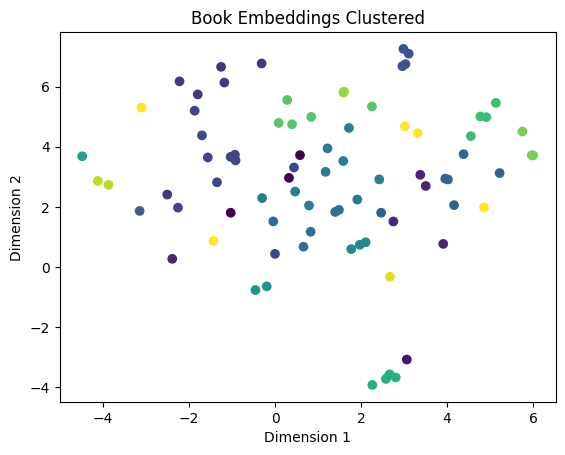

In [61]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [62]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [63]:
selected_indices = sorted(closest_indices)
selected_indices

[0, 1, 5, 14, 19, 28, 38, 42, 49, 54, 56, 58, 60, 62, 65, 66, 70, 71, 76, 78]

In [64]:
# Import libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import transformers
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [65]:
device

'cuda'

In [43]:
text_summarization_pipeline = transformers.pipeline("summarization", model="olonok/olonok_billsum_model")


llm = HuggingFacePipeline(pipeline=text_summarization_pipeline )

In [39]:
map_prompt = """
Summarize a single passage of a book. The section will be enclosed in triple backticks (```)
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
summary:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [44]:
map_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [69]:
selected_docs = [docs[doc] for doc in selected_indices]

In [70]:
from transformers import pipeline

summarizer = pipeline("summarization", model="olonok/olonok_billsum_model")

In [71]:
selected_docs[1].page_content

'------------------------------------------------------------------------\n\nMy family have been prominent, well-to-do people in this Middle\nWestern city for three generations. The Carraways are something of a\nclan, and we have a tradition that we’re descended from the Dukes of\nBuccleuch, but the actual founder of my line was my grandfather’s\nbrother, who came here in fifty-one, sent a substitute to the Civil\nWar, and started the wholesale hardware business that my father\ncarries on today.\n\nI never saw this great-uncle, but I’m supposed to look like him—with\nspecial reference to the rather hard-boiled painting that hangs in\nfather’s office. I graduated from New Haven in 1915, just a quarter of\na century after my father, and a little later I participated in that\ndelayed Teutonic migration known as the Great War. I enjoyed the\ncounter-raid so thoroughly that I came back restless. Instead of being\nthe warm centre of the world, the Middle West now seemed like the\nragged edge

In [72]:
response = summarizer(selected_docs[1].page_content)
response[0]['summary_text']

Token indices sequence length is longer than the specified maximum sequence length for this model (1031 > 1024). Running this sequence through the model will result in indexing errors


'a pair of enormous eggs, identical in contour and separated only by a courtesy bay, jut out into the most domesticated body of salt water in the Western hemisphere, the great wet barnyard of Long Island Sound . they are both crushed flat at the contact end, but their physical resemblance must be a source of perpetual wonder to the gulls that fly overhead. a more interesting phenomenon is their dissimilarity in every particular except shape and size.'

In [73]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):

    # Go get a summary of the chunk
    #chunk_summary = map_chain.run([doc])
    response = summarizer(doc.page_content)
    chunk_summary = response[0]['summary_text']
    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:500]} \n")

Summary #0 (chunk #0) - Preview: Project Gutenberg eBook of The Great Gatsby is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever . you may copy it, give it away or re-use it under the terms of the project Gutenberg License included with this ebook or online at www.gutenberg.org . if you are not located in the US, you will have to check the laws of the country where you are located before using this eBook . 

Summary #1 (chunk #1) - Preview: a pair of enormous eggs, identical in contour and separated only by a courtesy bay, jut out into the most domesticated body of salt water in the Western hemisphere, the great wet barnyard of Long Island Sound . they are both crushed flat at the contact end, but their physical resemblance must be a source of perpetual wonder to the gulls that fly overhead. a more interesting phenomenon is their dissimilarity in every particular except shape and size. 

Summary 

In [74]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2096 > 1024). Running this sequence through the model will result in indexing errors


Your total summary has 2096 tokens


In [75]:
print(summaries.page_content)

Project Gutenberg eBook of The Great Gatsby is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever . you may copy it, give it away or re-use it under the terms of the project Gutenberg License included with this ebook or online at www.gutenberg.org . if you are not located in the US, you will have to check the laws of the country where you are located before using this eBook .
a pair of enormous eggs, identical in contour and separated only by a courtesy bay, jut out into the most domesticated body of salt water in the Western hemisphere, the great wet barnyard of Long Island Sound . they are both crushed flat at the contact end, but their physical resemblance must be a source of perpetual wonder to the gulls that fly overhead. a more interesting phenomenon is their dissimilarity in every particular except shape and size.
Daisy retorted, “I’ve been trying to get you to New York all afternoon.” Her h

In [76]:
len(summaries.page_content)

8170

In [77]:
text_final = summaries.page_content
docsf = text_splitter.create_documents([text_final])
num_documents = len(docsf)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 2 documents


In [78]:
# Make an empty list to hold your summaries
summary_final = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(docsf):

    # Go get a summary of the chunk
    #chunk_summary = map_chain.run([doc])
    response = summarizer(doc.page_content)
    chunk_summary = response[0]['summary_text']
    # Append that summary to your list
    summary_final.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:500]} \n")

Summary #0 (chunk #0) - Preview: Project Gutenberg eBook of The Great Gatsby is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever . if you are not located in the US, you will have to check the laws of the country where you are located before using this eBook . 

Summary #1 (chunk #1) - Preview: Tom Gatsby and his wife, Daisy, were married in the middle of June in Louisville, Tennessee . they lived just two doors from the church, and he stayed three weeks until Daddy told him he had to get out. the day after he left Daddy died. “If we were young we’d rise and dance,” said Daisy. “I used to know a Bill Biloxi from Memphis,” she remarked. “He was a friend of his.” “I’d never seen him before.” 



In [79]:
summary_final = "\n".join(summary_final)

# Convert it back to a document
summaries = Document(page_content=summary_final)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 182 tokens


In [81]:
print(summaries.page_content)

Project Gutenberg eBook of The Great Gatsby is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever . if you are not located in the US, you will have to check the laws of the country where you are located before using this eBook .
Tom Gatsby and his wife, Daisy, were married in the middle of June in Louisville, Tennessee . they lived just two doors from the church, and he stayed three weeks until Daddy told him he had to get out. the day after he left Daddy died. “If we were young we’d rise and dance,” said Daisy. “I used to know a Bill Biloxi from Memphis,” she remarked. “He was a friend of his.” “I’d never seen him before.”


In [82]:
len(summaries.page_content)

720